# Pixel Art Upscale

Graphics in past video games were represented at the pixel level. This form of digital art is known as pixel art. This artwork was usually arranged by hand at the pixel level because of the hardware constraints at the time–this is opposed to the standard now of doscaling the high-resolution images.

We will be attempting to upscaling some iconic pixel art such as mario characters and other classic video game characters. We will start with some older implementation methods that have limitations on the magnification factor and we will finish with the most refined implementation developed by **Johannes Kopf and Dani Lischinski**.

The implementation by Kopf and Lischinski is most definitely the most advanced algorithm of the 3 that we are attempting to implement. Part of the difficulty is that we do not know what heuristics they are using so we will have to experiment with these numbers on are own. Additionally, have a low number of linear transformations needed, opposed to Kopf and Lischinski's which will require us to reshape the pixels, produce a Voroni graph, initialize spline curves, optimize the spline curves for control points, and render the image based off pixel-color averages.


# Install packages


In [63]:
%conda install --yes --prefix {sys.prefix} networkx

Retrieving notices: ...working... done

EnvironmentLocationNotFound: Not a conda environment: /home/zypherwind/Documents/Github/pixel_art/{sys.prefix}


Note: you may need to restart the kernel to use updated packages.


In [64]:
from epx import *
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from similarityGraph import *
import sys
from utils import * 
import networkx as nx

%matplotlib inline

# Option 1: Bicubic Upscaling

Apply linear filtering to upsample images


# Option 2: Pixel Art Upscaling Techniques

Emulation technique that is based on a fixed integer factor EPX.

EPX is a naive solution that increases the resolution of an image by a factor of two using a straightforward approach. At the beginning, every pixel in the original image is replaced by a 2x2 block of pixels with the same color. However, if the adjacent pixels to the left and above the current pixel in the original image have the same color, that color is used to replace the top-left pixel in the 2x2 block. The same logic applies to the other three corners of the block. There are a few more additional constraints that deal with not doing replacement if 3 of the surrounding pixels are equivalent.

Further Detailing on Algorithm:

- https://en.wikipedia.org/wiki/Pixel-art_scaling_algorithms#:~:text=Eric's%20Pixel%20Expansion%20(EPX)%20is,or%20less%20double%20that%20resolution.


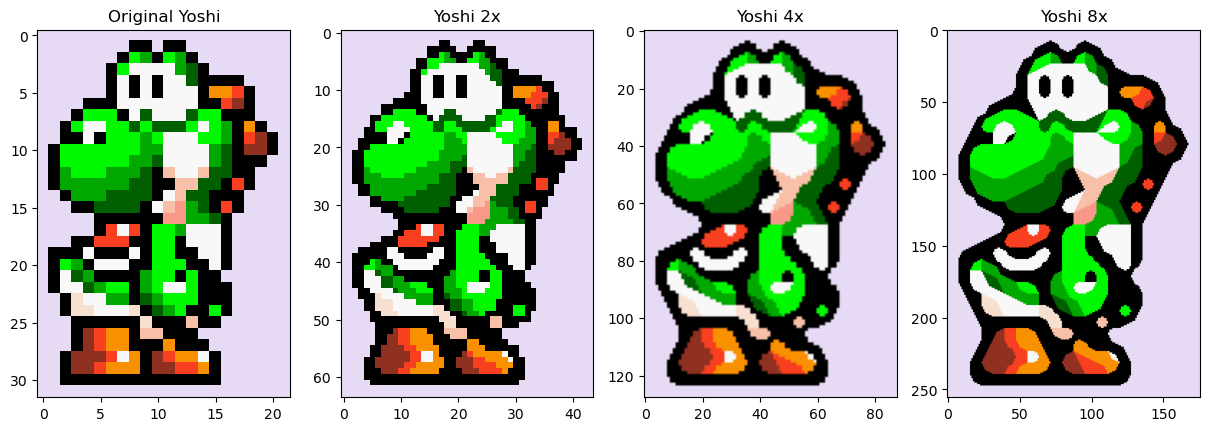

In [65]:
yoshi_path = 'inputs/yoshi.png'
yoshi = cv2.imread(yoshi_path)

yoshi_2x = epx_upsample(yoshi)
yoshi_4x = epx_upsample(yoshi_2x)
yoshi_8x = epx_upsample(yoshi_4x)
display_upscales("Yoshi", [yoshi, yoshi_2x, yoshi_4x, yoshi_8x])

# Option 3 Kopf and Lischinski Algorithm

Milestone steps to upscale 8-bit pixel art vectors:

- Milestone 1: Reshaping the pixels using the heuristics to make sure that they are grouped with their neighbors by creating a similarity graph
- Milestone 2: Create a simplified Voronoi graph from a similarity graph
- Milestone 3: Initializing spline curves from the Voronoi graph
- Milestone 4: Optimizing spline curves by improving locations of control point
- Milestone 5: Rendering


In [66]:
def createRegions(graph, image):
	height, width = image[ :, :, 0].shape
	voronoiPts = [[[] for j in range(height)] for j in range(width)]
	# {TOP_LEFT, std::make_pair(-1, -1)},
    # {TOP, std::make_pair(0, -1)},
    # {TOP_RIGHT, std::make_pair(1, -1)},
    # {BOTTOM_LEFT, std::make_pair(-1, 1)},
    # {BOTTOM, std::make_pair(0, 1)},
    # {BOTTOM_RIGHT, std::make_pair(1, 1)},
    # {LEFT, std::make_pair(-1, 0)},
    # {RIGHT, std::make_pair(1, 0)}
	# float xcenter, ycenter;
	for x in range(width):
		for y in range(height):
			pixel = (x, y)
			xcenter = x + 0.5
			ycenter = y + 0.5

            # TOPLEFT
			if(graph.has_edge(pixel, (pixel[0] -1, pixel[1] - 1))):
				voronoiPts[x][y].append((xcenter - 0.25, ycenter - 0.75)) # 1
				voronoiPts[x][y].append((xcenter - 0.75, ycenter - 0.25)) # 2
			elif (graph.has_edge((pixel[0], pixel[1] - 1), (pixel[0] - 1, pixel[1] + 1))):
				voronoiPts[x][y].append((xcenter - 0.25, ycenter - 0.25)) # 3
			else:
				voronoiPts[x][y].append((xcenter - 0.5, ycenter - 0.5)) # 4

		    # LEFT
			voronoiPts[x][y].append((xcenter - 0.5, ycenter)) # Mid-point

			# BOTTOMLEFT
			if (graph.has_edge(pixel,(pixel[0] - 1, pixel[1] + 1))):
				voronoiPts[x][y].append((xcenter - 0.75, ycenter + 0.25)) # 1
				voronoiPts[x][y].append((xcenter - 0.25, ycenter + 0.75)) # 2
			elif (graph.has_edge((pixel[0], pixel[1] + 1), (pixel[0] -1, pixel[1] - 1))):
				voronoiPts[x][y].append((xcenter - 0.25, ycenter + 0.25)) # 3
			else:
				voronoiPts[x][y].append((xcenter - 0.5, ycenter + 0.5)) # 4

			# BOTTOM
			voronoiPts[x][y].append((xcenter, ycenter + 0.5)) # Mid-point

            # BOTTOMRIGHT
			if(graph.has_edge(pixel, (pixel[0] + 1, pixel[0] + 1))):
				voronoiPts[x][y].append((xcenter + 0.25, ycenter + 0.75)) # 1
				voronoiPts[x][y].append((xcenter + 0.75, ycenter + 0.25)) # 2
			elif(graph.has_edge((pixel[0], pixel[1] + 1),(pixel[0] + 1, pixel[1] - 1))):
				voronoiPts[x][y].append((xcenter + 0.25, ycenter + 0.25)) # 3
			else:
				voronoiPts[x][y].append((xcenter + 0.5, ycenter + 0.5)) # 4

            # RIGHT
			voronoiPts[x][y].append((xcenter + 0.5, ycenter)) # Mid-point

            # TOPRIGHT
			if(graph.has_edge(pixel, (pixel[0] -1, pixel[1] + 1))):
				voronoiPts[x][y].append((xcenter + 0.75, ycenter - 0.25)) # 1
				voronoiPts[x][y].append((xcenter + 0.25, ycenter - 0.75)) # 2
			elif(graph.has_edge((pixel[0], pixel[1] - 1), (pixel[0] + 1, pixel[1] + 1))):
				voronoiPts[x][y].append((xcenter + 0.25, ycenter - 0.25)) # 3
			else:
				voronoiPts[x][y].append((xcenter + 0.5, ycenter - 0.5)) # 4

            # TOP
			voronoiPts[x][y].append((xcenter, ycenter - 0.5)) # Mid-point
	return voronoiPts

def collapseValence(voronoiPts, width, height):
	valency = {}
	for x in range(width):
		for y in range(height):
			for i in range(len(voronoiPts[x][y])):
				l = i
				r = (i+1)%(len(voronoiPts[x][y]))
				if (valency.get(voronoiPts[x][y][l])):
						valency[voronoiPts[x][y][l]] += 1
				else:
					valency[voronoiPts[x][y][l]] = 1

				if(valency.get(voronoiPts[x][y][r])):
						valency[voronoiPts[x][y][r]] += 1
				else:
					valency[voronoiPts[x][y][r]] = 1;

	for x in range(width):
		for y in range(height):
			temp = [];
			for i in range(len(voronoiPts[x][y])):
				if(valency[voronoiPts[x][y][i]] != 4 or onBoundary(voronoiPts[x][y][i], height, width)):
					temp.append(voronoiPts[x][y][i])
			voronoiPts[x][y].clear()
			voronoiPts[x][y] = temp

	return voronoiPts

def onBoundary(point, height, width):
	return point[0] == 0 or point[0] == width or point[1] == 0 or point[1] == height


(0, 0)
Curve Score [1 1]
Sparse Score [2 2]
Island [5 5]



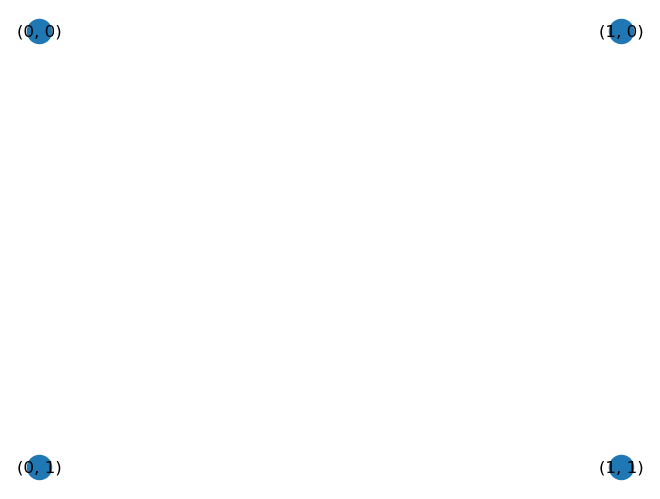

In [67]:
boo_arm_file = './inputs/boo_arm3.png'
boo_arm = cv2.imread(boo_arm_file)

graph = create_similarity_graph(boo_arm)
graph = remove_diagonals(graph, boo_arm)
pos = {(x,y):(x, -y) for x, y in graph.nodes()}
nx.draw(graph, pos=pos, with_labels=True)


In [68]:
def get_voronoi_nodes(graph):
    nodes = [node for node in graph.nodes()]
    
    for edge in graph.edges():
        midpoint = ((edge[0][0] + edge[1][0]) / 2, (edge[0][1] + edge[1][1]) / 2)
        nodes.append(midpoint)

    return np.array(nodes)


In [69]:
import scipy as sp

def in_box(towers, bounding_box):
    return np.logical_and(np.logical_and(bounding_box[0] <= towers[:, 0],
                                         towers[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= towers[:, 1],
                                         towers[:, 1] <= bounding_box[3]))


def voronoi(towers, bounding_box):
    eps = sys.float_info.epsilon

    # Select towers inside the bounding box
    i = in_box(towers, bounding_box)
    # Mirror points
    points_center = towers[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    for region in vor.regions:
        flag = True
        for index in region:
            if index == -1:
                flag = False
                break
            else:
                x = vor.vertices[index, 0]
                y = vor.vertices[index, 1]
                if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                       bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                    flag = False
                    break
        if region != [] and flag:
            regions.append(region)
    vor.filtered_points = points_center
    vor.filtered_regions = regions
    return vor

def on_boundary(point, width, height):
    return point[0] == 0 or point[1] == 0 or point[0] == width or point[1] == height

In [91]:
def get_segments(width, height, points, image):
    bounding_box = np.array([-1, width, -1, height])
    vor = voronoi(points, bounding_box)

    fig = plt.figure()
    ax = fig.gca()
    ax.set_xlim([0.0, width - 1])
    ax.set_ylim([0.0, height - 1])
    ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')

    # Get line segments and plot
    segments = set()
    print(len(vor.vertices), len(vor.filtered_points))
    for index, region in enumerate(vor.filtered_regions):
        vertices = vor.vertices[region + [region[0]], :]
        print("region", vertices)
        point = vor.filtered_points[index]
        c = tuple(image[int(point[1]), int(point[0])])
        ax.fill([vertex[0] for vertex in vertices], [vertex[1] for vertex in vertices], color=(c[0]/255.0, c[1]/255.0, c[2]/255.0))
        # Get the line segments
        prev_on_boundary = on_boundary(vertices[0], width, height)
        prev_on_boundary = (vertices[0] in points)
        for i in range(1, len(vertices)):
            curr_on_boundary = on_boundary(vertices[i], width, height)
            curr_on_boundary = (vertices[i] in points)
            if (not prev_on_boundary) ^ (not curr_on_boundary):
                point1 = (vertices[i - 1][0], vertices[i - 1][1])
                point2 = (vertices[i][0], vertices[i][1])
                if (point2, point1) not in segments:
                    segments.add((point1, point2))
            prev_on_boundary = curr_on_boundary

    segments = np.array([np.array([np.array([x, y]) for x, y in tup]) for tup in segments])    

    return segments

17 4
region [[2.  0.5]
 [2.  2. ]
 [0.5 2. ]
 [0.5 0.5]
 [2.  0.5]]
region [[-1.   2. ]
 [ 0.5  2. ]
 [ 0.5  0.5]
 [-1.   0.5]
 [-1.   2. ]]
region [[ 0.5  0.5]
 [ 0.5 -1. ]
 [ 2.  -1. ]
 [ 2.   0.5]
 [ 0.5  0.5]]
region [[ 0.5  0.5]
 [-1.   0.5]
 [-1.  -1. ]
 [ 0.5 -1. ]
 [ 0.5  0.5]]


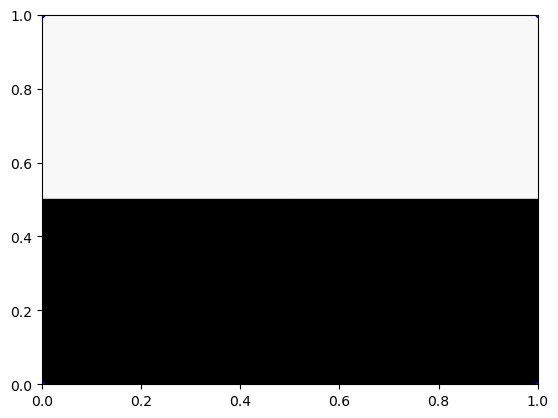

In [92]:
height, width, _ = boo_arm.shape
points = get_voronoi_nodes(graph)
segments = get_segments(width, height, points, boo_arm)

# for segment in segments:
#     print(segment)

# Run all the helpers
